# Notes
The program seems to run normally, but the created map does not seem to be correct. I think the "self.individual" value is incorrect

The range for the y_vel is from 0 to -3
The range for x_pos is -1 to 1

Scores should always be above -600 for the simualtions, so we need to add an offset of 600, so the results are always above 0. Thi


# TO-DO
- Add new simulation code, may want to use the code in CMA-ME Tutorial
the while loop to run simulation
- Add evolutionary process. Need to figure out how.


# Fixed
- Heatmap fixed, but needs more testing

# Important Links

https://docs.pyribs.org/en/stable/tutorials/lunar_lander.html#setup
Has the original lunarlander tutorial from pyribs

Lunar Lander Documentation from Gym
https://gymnasium.farama.org/environments/box2d/lunar_lander/

In [1]:
pip install swig

In [2]:
pip install ribs[visualize] gymnasium[box2d]==0.27.0 "moviepy>=1.0.0"

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

# Lunar Lander simulation environment
env = gym.make("LunarLander-v2")
new_step_api=True

# Seed for all environments in this notebook.
env_seed = 52

In [4]:
class GameEvaluator:
    def __init__(self, seed=1009, num_rep=1):
        self.env = env
        self.seed = seed
        self.num_rep = num_rep
        self.num_actions = self.env.action_space.n
        #print(self.num_actions)

    def run(self, agent, render=False):
        agent.fitness = 0
        observation = env.reset(seed=self.seed)

        action_frequency = [0] * self.num_actions

        action_count = 0
        done = False

        #The sumulation
        while not done:
            #if render:
            #    env.render()

            pos = min(action_count//self.num_rep, len(agent.commands)-1)
            action = agent.commands[pos]
            action_count += 1

            observation, reward, done, info, _ = env.step(action)
            agent.fitness += reward
            action_frequency[action] += 1

        final_observation = list(observation)


        agent.features = (agent.fitness, agent.fitness)
        agent.action_count = action_count

In [5]:
def create_sequence(sequence_length=-1):
  #Generate random action sequence, length of 100
  sequence = ""
  for i in range(100):
    new_action = random.randint(0, 3)
    sequence += str(new_action)

  return sequence


In [6]:
game_eva = GameEvaluator()
class Agent:
    def __init__(self, sequence_length=10, action_sequence=str(0000000000)):
        #Starts at 0 and is updated during simulation
        self.fitness = 0
        self.action_count = 0
        self.features = (0,0)

        #The length of the sequence and the commands the agent can take (0,1,2,or 3)
        self.commands = [int(char) for char in action_sequence]
        #print(self.commands)
        self.sequence_length = len(self.commands)

        self.simulate_agent()

    #Mutates the agent
    def mutate(self):

      pass

    def is_feasible(self):
        #Need to fix by better defining feasiblity
        return self.fitness > -500


    def simulate_agent(self):
      game_eva.run(self)


In [7]:
#This is to make it easier to round
def round_nearest(x, a):
    return round(round(x / a) * a, 2)

# Map-Elites Creation


In [8]:
#NOTE: Right now assumed that the values are integers, so doesn't work with the lunarlander
# Define the Simulation class

#INPUTl The bounds, the step (ie distance between bounds), the number of generations wanted
def map_elites(bounds = [(-2000,1000),(-2000,1000)], step=1, num_generations = 10000):


    #bounds is the dimensions of the search space
    #num_bins is the number of bins in each section of the map.

    #NUM BINS CALCULATION
    # BINS1 = (ABS(BOUND1) + ABS(BOUND2) + 1 ) / STEP

    bins1 = (abs(bounds[0][0]) + abs(bounds[0][1]) + 1) / step
    bins2 = (abs(bounds[1][0]) + abs(bounds[1][1]) + 1) / step
    num_bins = [bins1, bins2]


    #Here we want to create 2 maps. One for feasible and one for infeasible
    map_elites_infeasible = {}
    map_elites_feasible = {}
    for i in np.arange(bounds[0][0], bounds[0][1] + 1, step):
        #Have to round because arange gives miscallenious values
        #ie it gives 8e-12 instead of 0, or 2.5000000007 instead of 2.5
        i = round_nearest(i, step)
        for j in np.arange(bounds[1][0], bounds[1][1] + 1, step):
            j = round_nearest(j,step)
            map_elites_feasible[(i, j)] = {'solution': None, 'fitness': -np.inf}
            map_elites_infeasible[(i, j)] = {'solution': None, 'fitness': -np.inf}

    #For number of generations, create a new simulation
    for i in range(num_generations):

        #Create Agent
        simul = Agent(action_sequence=create_sequence())



        #Use the simulate x and y as placing points for the bins
        bin_index = (round_nearest(simul.features[0], step), round_nearest(simul.features[1], step))

        #If feasible put in one map-elites
        if simul.is_feasible():
            #If better score, replace
            if simul.fitness > map_elites_feasible[bin_index]['fitness']:
                #Solution is the new simulation
                map_elites_feasible[bin_index]['solution'] = simul
                #fitness is the new score
                map_elites_feasible[bin_index]['fitness'] = simul.fitness
        #If not feasible do the same in the non_feasible map_elites
        else:
            if simul.fitness > map_elites_infeasible[bin_index]['fitness']:
                #Solution is the new simulation
                map_elites_infeasible[bin_index]['solution'] = simul
                #fitness is the new score
                map_elites_infeasible[bin_index]['fitness'] = simul.fitness
        #print(bin_index)
        #print(map_elites_infeasible[bin_index]['fitness'])
    #Return Syntax:
    #

    return (map_elites_feasible, map_elites_infeasible)






# Heat Map

In [9]:
def map_elites_to_heatmap(map_elite_dict, num_bins=[23,23],  bounds = [(-200,100),(-200,100)], step=1):

    #Calculate the number of square needed. The calculation is based on the range of the bounds
    #divided by the step size.
    #Note: added +1 to account for 0

    #Get the keys
    row_keys = np.arange(bounds[0][0], bounds[0][1] + 1, step)
    col_keys = np.arange(bounds[1][0], bounds[1][1] + 1, step)

    #Fixed values
    #This stores the values that are going to be "fixed" (rounded) later on
    row_keys_fixed = np.zeros(len(row_keys))
    col_keys_fixed = np.zeros(len(row_keys))



    num_rows = len(row_keys)
    num_cols = len(col_keys)

    num_bins = [num_rows, num_cols]


    # Create an empty 2D array to represent the heatmap
    heatmap = np.zeros((int(num_bins[0]), int(num_bins[1])))

    # Populate the heatmap with the fitness values from the map elites

    for x_index in range(len(row_keys)):
      #Round the row key to fix decimal problems
      i = round_nearest(row_keys[x_index], step)
      row_keys[x_index] = i

      for y_index in range(len(col_keys)):
        j = round_nearest(col_keys[y_index], step)
        col_keys[y_index] = j

        #Put the value of the map-elite into the heatmap
        map_val = map_elite_dict[(i,j)]['fitness']
        if map_val > -5000:
            heatmap[:,y_index] = np.full(heatmap[:,y_index].shape, map_val)
        




    # Create the heatmap plot
    plt.imshow(heatmap.T, origin='lower', extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]])
    plt.colorbar(label='Value')

    # Label the axes
    plt.xlabel('X')
    plt.ylabel('Y')

    #Label so that the array matches the numbers
    #plt.xticks(num_rows, row_keys)
    #plt.yticks(num_cols, col_keys)
    
    print(heatmap)
    # Show the plot
    plt.show()









def create_heatmap(data_dict):
    # Extract the keys and values from the dictionary
    keys = list(data_dict.keys())
    values = list(data_dict.values())

    print(keys)
    print(values)

    # Determine the size of the heatmap grid
    x_values = sorted(set([key[0] for key in keys]))
    y_values = sorted(set([key[1] for key in keys]))
    num_rows = len(y_values)
    num_cols = len(x_values)

    # Create an empty grid of zeros
    heatmap_grid = np.zeros((num_rows, num_cols))

    # Fill in the grid with the values from the dictionary
    for i, key in enumerate(keys):
        print(type(i))
        print(type(key))
        x_index = x_values.index(key[0])
        y_index = y_values.index(key[1])

        heatmap_grid[y_index, x_index] = values[i]

    # Create the heatmap
    plt.imshow(heatmap_grid, cmap='hot')
    plt.colorbar(label='Value')

    plt.xlabel('X')
    plt.ylabel('Y')

    # Customize the x-tick labels
    #plt.xticks(range(num_cols), x_values)
    #plt.yticks(range(num_rows), y_values)

    plt.show()


[[-199.50953984 -198.51409748 -197.5178182  ...    0.
     0.            0.        ]
 [-199.50953984 -198.51409748 -197.5178182  ...    0.
     0.            0.        ]
 [-199.50953984 -198.51409748 -197.5178182  ...    0.
     0.            0.        ]
 ...
 [-199.50953984 -198.51409748 -197.5178182  ...    0.
     0.            0.        ]
 [-199.50953984 -198.51409748 -197.5178182  ...    0.
     0.            0.        ]
 [-199.50953984 -198.51409748 -197.5178182  ...    0.
     0.            0.        ]]


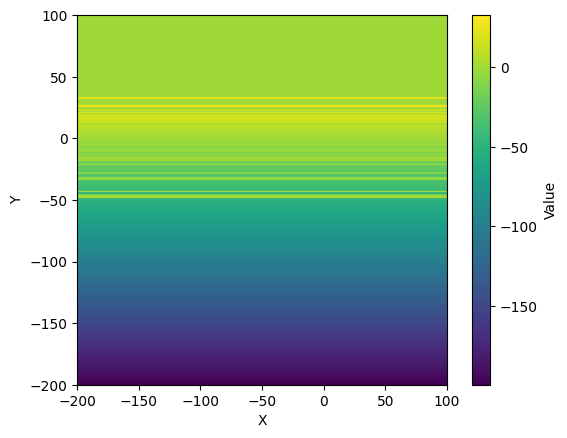

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


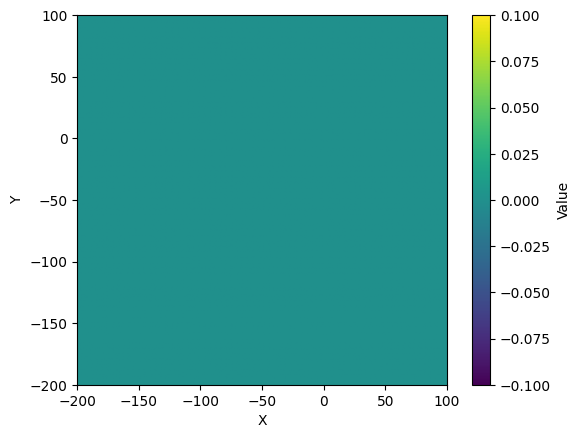

In [10]:
    #bounds
    map_bounds = [(-2000, 1000), (-2000, 1000)]
    
    #Creates the map elites
    ME = map_elites()

    #Creates the heatmaps and displays them
    map_elites_to_heatmap(ME[0])
    map_elites_to_heatmap(ME[1])